# Download & Subset HyP3 SBAS Stack (InSAR or Burst-InSAR)

*Author: Alex Lewandowski; Alaska Satellite Facility*

This notebook assumes that you have already ordered processing for an InSAR Short Baseline Subset (SBAS) stack using [ASF HyP3](https://hyp3-docs.asf.alaska.edu/), available in a web browser at [ASF Vertex](https://search.asf.alaska.edu/) or programmatically with [hyp3-sdk](https://github.com/ASFHyP3/hyp3-sdk).

---
## 0. Import Required Software 

In [27]:
import copy
from datetime import datetime, timedelta
from ipyfilechooser import FileChooser
import ipywidgets as widgets
from itertools import chain
import json
from pathlib import Path
import re
import requests
import shutil
import sys
from tqdm.auto import tqdm
from typing import Union

import numpy as np
from osgeo import gdal
gdal.UseExceptions()
import pandas
from rasterio.warp import transform_bounds

import opensarlab_lib as osl

from hyp3_sdk import Batch, HyP3

from IPython.display import Markdown, display, clear_output

current = Path("..").resolve()
sys.path.append(str(current))
import util.util as util

%matplotlib widget

---

## 1. Select or create a working directory for the analysis

In [28]:
age = osl.select_parameter(
    [
        "Download new SBAS stack",
        "Add to existing SBAS stack"
    ]
)
display(age)

RadioButtons(layout=Layout(min_width='800px'), options=('Download new SBAS stack', 'Add to existing SBAS stack…

In [29]:
new = 'new' in age.value

if new:
    print(f'Current working directory: {Path.cwd()}')
    print('Create a new directory to hold your data:')
    data_path = input(f'Enter an unused path for a new data directory:  {Path.home()}/')
    try:
        data_path = Path.home() / data_path.strip()
        data_path.mkdir()
    except:
        raise
else:
    path = Path.cwd()
    fc = FileChooser(path)
    display(fc)

Current working directory: /home/jovyan/opensarlab_MintPy_Recipe_Book
Create a new directory to hold your data:


Enter an unused path for a new data directory:  /home/jovyan/ AZ_burst_2


In [30]:
if not new:
    data_path = Path.home()/fc.selected_path

---

## 2. Download SBAS Stack from HyP3

**Create a HyP3 object and authenticate**

In [31]:
hyp3 = HyP3(prompt=True)

NASA Earthdata Login username:  aflewandowski
NASA Earthdata Login password:  ········


**You may search for InSAR projects in your own account or download data from any user's account**

- Downloading data from another user's account only requires their username and the project name.
- It does **not** require the other user's password. 

In [32]:
hyp3_project = osl.select_parameter(
    [
        'Download InSAR data with any valid HyP3 username and HyP3 Project Name',
        'Search your Projects for available InSAR data'
    ]
)
display(hyp3_project)

RadioButtons(layout=Layout(min_width='800px'), options=('Download InSAR data with any valid HyP3 username and …

**Select your SBAS stack's HyP3 product type**

In [33]:
product_select = osl.select_parameter(
    [
        'INSAR_GAMMA',
        'INSAR_ISCE_BURST'
    ]
)
print("Select your SBAS stack's HyP3 product type")
display(product_select)

Select your SBAS stack's HyP3 product type


RadioButtons(layout=Layout(min_width='800px'), options=('INSAR_GAMMA', 'INSAR_ISCE_BURST'), value='INSAR_GAMMA…

In [34]:
product_type = product_select.value

search = "Search" in hyp3_project.value
if search:
    my_hyp3_info = hyp3.my_info()
    active_projects = dict()
    
    print("Checking all HyP3 projects for current INSAR_GAMMA jobs")
    for project in tqdm(my_hyp3_info['job_names']):
            batch = Batch()
            batch = hyp3.find_jobs(
                name=project, 
                job_type=product_type
            ).filter_jobs(running=False, include_expired=False)
            if len(batch) > 0:
                active_projects.update({batch.jobs[0].name: batch})
    
    if len(active_projects) > 0:
        display(Markdown("<text style='color:darkred;'>Note: After selecting a project, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>"))
        display(Markdown("<text style='color:darkred;'>Otherwise, you will rerun this code cell.</text>"))
        print('\nSelect a Project:')
        project_select = osl.select_parameter(active_projects.keys())
        display(project_select)
    else:
        print("Found no active projects containing InSAR products")
else:
    username = input("enter the HyP3 username on the account containing an SBAS stack to download")
    project_name = input("Enter the HyP3 project name")
    batch = Batch()
    batch = hyp3.find_jobs(
        name=project_name, 
        job_type=product_type, 
        user_id=username
    ).filter_jobs(running=False, include_expired=False)

enter the HyP3 username on the account containing an SBAS stack to download aflewandowski
Enter the HyP3 project name AZ_PX_burst


**Select a date range of products to download:**

In [35]:
if search:
    jobs = active_projects[project_select.value]
else:
    jobs = batch

display(Markdown("<text style='color:darkred;'>Note: After selecting a date range, you should select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>"))
display(Markdown("<text style='color:darkred;'>Otherwise, you may simply rerun this code cell.</text>"))
print('\nSelect a Date Range:')
dates = osl.get_job_dates(jobs)
date_picker = osl.gui_date_picker(dates)
display(date_picker)

<text style='color:darkred;'>Note: After selecting a date range, you should select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>

<text style='color:darkred;'>Otherwise, you may simply rerun this code cell.</text>


Select a Date Range:


SelectionRangeSlider(description='Dates', index=(0, 264), layout=Layout(width='500px'), options=((' 06/22/2023…

**Save the selected date range and remove products falling outside of it:**

In [36]:
date_range = osl.get_slider_vals(date_picker)
date_range[0] = date_range[0].date()
date_range[1] = date_range[1].date()
print(f"Date Range: {str(date_range[0])} to {str(date_range[1])}")
jobs = osl.filter_jobs_by_date(jobs, date_range)

Date Range: 2023-06-22 to 2024-03-10


**Gather the available paths and orbit directions for the remaining products:**

In [37]:
display(Markdown("<text style='color:darkred;'><text style='font-size:150%;'>This may take some time for projects containing many jobs...</text></text>"))
osl.set_paths_orbits(jobs)
paths = set()
orbit_directions = set()
for p in jobs:
    paths.add(p.path)
    orbit_directions.add(p.orbit_direction)
display(Markdown(f"<text style=color:blue><text style='font-size:175%;'>Done.</text></text>"))

<text style='color:darkred;'><text style='font-size:150%;'>This may take some time for projects containing many jobs...</text></text>

<text style=color:blue><text style='font-size:175%;'>Done.</text></text>

**Select a path:**

- Sentinel-1 has a 12-day repeat cycle so it is not appropriate to merge interferograms across multiple orbital paths. 
- If multiple paths are represented in the SBAS stack, you select one.

In [38]:
display(Markdown("<text style='color:darkred;'>Note: After selecting a path, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>"))
display(Markdown("<text style='color:darkred;'>Otherwise, you will simply rerun this code cell.</text>"))
print('\nSelect a Path:')
path_choice = osl.select_parameter(paths)
display(path_choice)

<text style='color:darkred;'>Note: After selecting a path, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>

<text style='color:darkred;'>Otherwise, you will simply rerun this code cell.</text>


Select a Path:


RadioButtons(layout=Layout(min_width='800px'), options=(27,), value=27)

**Save the selected flight path/s:**

In [39]:
flight_path = path_choice.value
if flight_path:
    if flight_path:
        print(f"Flight Path: {flight_path}")
    else:
        print('Flight Path: All Paths')
else:
    print("WARNING: You must select a flight path in the previous cell, then rerun this cell.")

Flight Path: 27


**Select an orbit direction:**

- MintPy is able to decompose 2 Line-Of-Sight (LOS) displacement time series, acquired from different orbit directions, into a vertical displacement time series
- Each LOS time series must be processed individually

In [40]:
if len(orbit_directions) > 1:
    display(Markdown("<text style='color:red;'>Note: After selecting a flight direction, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>"))
    display(Markdown("<text style='color:red;'>Otherwise, you will simply rerun this code cell.</text>"))
print('\nSelect a Flight Direction:')
direction_choice = osl.select_parameter(orbit_directions, 'Direction:')
display(direction_choice)


Select a Flight Direction:


RadioButtons(description='Direction:', layout=Layout(min_width='800px'), options=('DESCENDING',), value='DESCE…

**Save the selected orbit direction:**

In [41]:
direction = direction_choice.value
print(f"Orbit Direction: {direction}")

Orbit Direction: DESCENDING


**Filter jobs by path and orbit direction:**

In [42]:
jobs = osl.filter_jobs_by_path(jobs, [flight_path])
jobs = osl.filter_jobs_by_orbit(jobs, direction)
print(f"There are {len(jobs)} products to download.")

There are 22 products to download.


**Download the products, unzip them into a directory named after the product type, and delete the zip files:**

In [43]:
print(f"\nProject: {jobs.jobs[0].name}")
project_zips = jobs.download_files(data_path)
for z in project_zips:
    osl.asf_unzip(str(data_path), str(z))
    z.unlink()


Project: AZ_PX_burst


  0%|          | 0/22 [00:00<?, ?it/s]

S1_056723_IW3_20231231_20240112_VV_INT80_CF71.zip:   0%|          | 0/15063045 [00:00<?, ?it/s]

S1_056723_IW3_20230728_20230809_VV_INT80_C562.zip:   0%|          | 0/15195377 [00:00<?, ?it/s]

S1_056723_IW3_20240205_20240217_VV_INT80_2CF4.zip:   0%|          | 0/15078987 [00:00<?, ?it/s]

S1_056723_IW3_20231125_20231207_VV_INT80_FC0C.zip:   0%|          | 0/15095725 [00:00<?, ?it/s]

S1_056723_IW3_20240217_20240229_VV_INT80_D68C.zip:   0%|          | 0/15088276 [00:00<?, ?it/s]

S1_056723_IW3_20230809_20230821_VV_INT80_F9F8.zip:   0%|          | 0/15315000 [00:00<?, ?it/s]

S1_056723_IW3_20230716_20230728_VV_INT80_D016.zip:   0%|          | 0/15170281 [00:00<?, ?it/s]

S1_056723_IW3_20230821_20230902_VV_INT80_DE5F.zip:   0%|          | 0/15265227 [00:00<?, ?it/s]

S1_056723_IW3_20231008_20231020_VV_INT80_ED31.zip:   0%|          | 0/15145187 [00:00<?, ?it/s]

S1_056723_IW3_20231020_20231101_VV_INT80_7736.zip:   0%|          | 0/15113828 [00:00<?, ?it/s]

S1_056723_IW3_20240229_20240312_VV_INT80_C547.zip:   0%|          | 0/15121809 [00:00<?, ?it/s]

S1_056723_IW3_20231207_20231219_VV_INT80_00FE.zip:   0%|          | 0/15214055 [00:00<?, ?it/s]

S1_056723_IW3_20231219_20231231_VV_INT80_455E.zip:   0%|          | 0/15224977 [00:00<?, ?it/s]

S1_056723_IW3_20240124_20240205_VV_INT80_A98A.zip:   0%|          | 0/15218350 [00:00<?, ?it/s]

S1_056723_IW3_20230622_20230704_VV_INT80_A8BE.zip:   0%|          | 0/15135713 [00:00<?, ?it/s]

S1_056723_IW3_20230926_20231008_VV_INT80_CFDE.zip:   0%|          | 0/15224663 [00:00<?, ?it/s]

S1_056723_IW3_20230902_20230914_VV_INT80_850C.zip:   0%|          | 0/15270217 [00:00<?, ?it/s]

S1_056723_IW3_20230704_20230716_VV_INT80_F4C6.zip:   0%|          | 0/15184152 [00:00<?, ?it/s]

S1_056723_IW3_20231101_20231113_VV_INT80_1CAB.zip:   0%|          | 0/15152553 [00:00<?, ?it/s]

S1_056723_IW3_20231113_20231125_VV_INT80_EBC5.zip:   0%|          | 0/15275422 [00:00<?, ?it/s]

S1_056723_IW3_20230914_20230926_VV_INT80_A8A3.zip:   0%|          | 0/15234713 [00:00<?, ?it/s]

S1_056723_IW3_20240112_20240124_VV_INT80_6075.zip:   0%|          | 0/15291342 [00:00<?, ?it/s]

Extracting: /home/jovyan/AZ_burst_2/S1_056723_IW3_20231231_20240112_VV_INT80_CF71.zip
Extracting: /home/jovyan/AZ_burst_2/S1_056723_IW3_20230728_20230809_VV_INT80_C562.zip
Extracting: /home/jovyan/AZ_burst_2/S1_056723_IW3_20240205_20240217_VV_INT80_2CF4.zip
Extracting: /home/jovyan/AZ_burst_2/S1_056723_IW3_20231125_20231207_VV_INT80_FC0C.zip
Extracting: /home/jovyan/AZ_burst_2/S1_056723_IW3_20240217_20240229_VV_INT80_D68C.zip
Extracting: /home/jovyan/AZ_burst_2/S1_056723_IW3_20230809_20230821_VV_INT80_F9F8.zip
Extracting: /home/jovyan/AZ_burst_2/S1_056723_IW3_20230716_20230728_VV_INT80_D016.zip
Extracting: /home/jovyan/AZ_burst_2/S1_056723_IW3_20230821_20230902_VV_INT80_DE5F.zip
Extracting: /home/jovyan/AZ_burst_2/S1_056723_IW3_20231008_20231020_VV_INT80_ED31.zip
Extracting: /home/jovyan/AZ_burst_2/S1_056723_IW3_20231020_20231101_VV_INT80_7736.zip
Extracting: /home/jovyan/AZ_burst_2/S1_056723_IW3_20240229_20240312_VV_INT80_C547.zip
Extracting: /home/jovyan/AZ_burst_2/S1_056723_IW3_2023

---

## 3. Confirm Presence of a DEM, Azimuth Angle Map, and Incidence Angle Map

- These are optional addon products for HyP3, which are necessary for MintPy
    - Incidence angle maps are included with HyP3 jobs when the `Include Look Vectors` option is selected.
    - DEMs are included with HyP3 jobs when the `Include DEM` option is selected
- This is an optional addon product for HyP3, which is necessary for MintPy if running the correct_SET (Solid Earth Tides) step
    - Azimuth angle maps are included with HyP3 jobs when the `Include Look Vectors` option is selected

**All of the above mentioned files will be included in an InSAR project if Set MintPy Options is selected when adding InSAR jobs to a project in ASF-Search (Vertex)**

In [44]:
dems = list(data_path.glob('*/*dem*.tif'))
az_angle_maps = list(data_path.glob('*/*lv_phi*.tif'))
inc_angle_maps = list(data_path.glob('*/*lv_theta*.tif'))

if len(dems) > 0:
    print("Success: Found at least 1 DEM.")
else:
    raise FileNotFoundError("Failed to find at least 1 DEM. \
    \nYou will not be able to successfully run a MintPy time-series unless you reorder your HyP3 project \
with DEMS or provide one from another source.")
    
if len(az_angle_maps) > 0:
    print("Success: Found at least 1 Azimuth Angle Map.")
else:
    raise FileNotFoundError("Failed to find at least 1 Azimuth Angle Map. \
    \nYou will not be able to successfully run a MintPy time-series unless your reorder your HyP3 project \
with 'Include Look Vectors' option selected.")
    
if len(inc_angle_maps) > 0:
    print("Success: Found at least 1 Incidence Angle Map.")
else:
    raise FileNotFoundError("Failed to find at least 1 Incidence Angle Map. \
    \nYou will not be able to successfully run a MintPy time-series unless your reorder your HyP3 project \
with 'Include Inc. Angle Map' option selected.")

Success: Found at least 1 DEM.
Success: Found at least 1 Azimuth Angle Map.
Success: Found at least 1 Incidence Angle Map.


---
## 4. Subset the Stack

**Project all tiffs to Predominant UTM**

In [45]:
dems.sort()
burst = 'BURST' in product_type
if not burst:
    epsgs = util.get_projections(dems)
    predominant_epsg = None if len(epsgs) == 1 else max(epsgs, key=epsgs.get)
    
    if predominant_epsg:
        for pth in dems:
            src_SRS = util.get_projection(str(pth))
            res = util.get_res(pth)
            if src_SRS != predominant_epsg:
                res = util.get_res(pth)
                no_data_val = util.get_no_data_val(pth)
        
                temp = pth.parent/f"temp_{pth.stem}.tif"
                pth.rename(temp)
    
                warp_options = {
                    "dstSRS":f"EPSG:{predominant_epsg}", "srcSRS":f"EPSG:{src_SRS}",
                    "targetAlignedPixels":True,
                    "xRes":res, "yRes":res,
                    "dstNodata": no_data_val
                }
                gdal.Warp(str(pth), str(temp), **warp_options)
                temp.unlink()


**Determine the maximum and common extents of the stack and plot an Area-of_Interest Selector:**

[-12603791.93486395, 3937773.1110669537, -12487082.323323049, 3985795.479125295]
[-12603305.819274502, 3938167.5317569375, -12487565.016214723, 3985500.461561431]


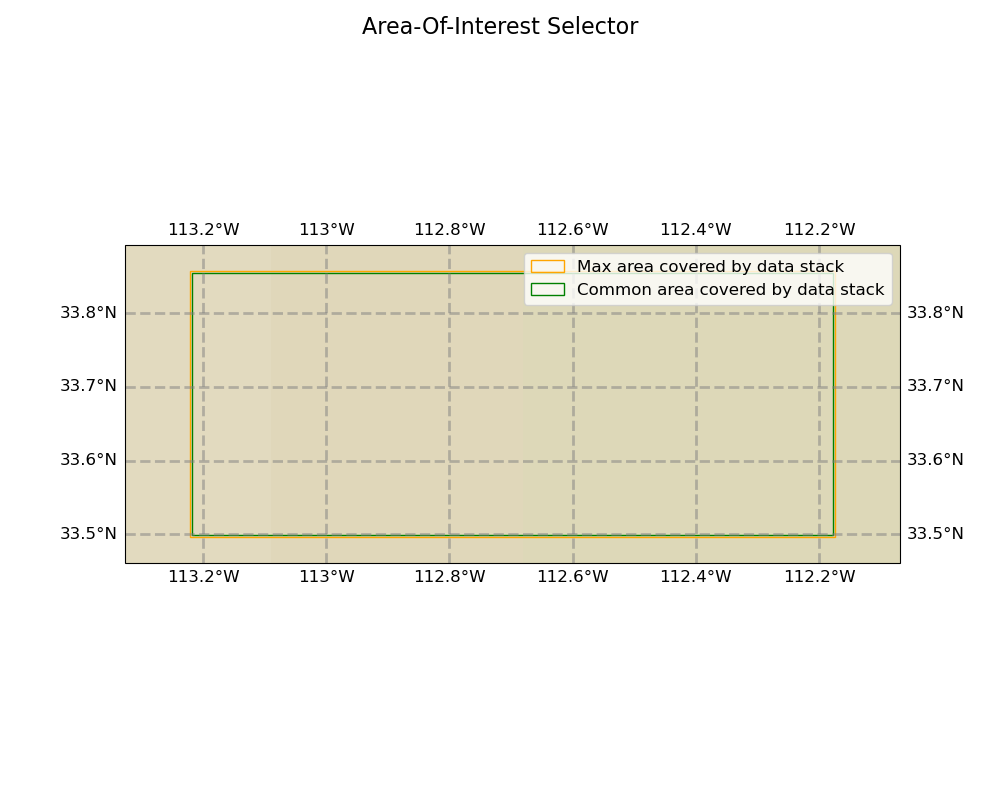

In [46]:
max_extents = osl.get_max_extents(dems)
xmin, ymin, xmax, ymax = transform_bounds(int(osl.get_projection(str(dems[0]))), 3857, *max_extents)
max_extents = [xmin, ymin, xmax, ymax]

common_extents = osl.get_common_coverage_extents(dems)
xmin, ymin, xmax, ymax = transform_bounds(int(osl.get_projection(str(dems[0]))), 3857, *common_extents)
common_extents = [xmin, ymin, xmax, ymax]

print(max_extents)
print(common_extents)

aoi = osl.AOI_Selector(max_extents, common_extents, figsize=(10, 8))

**Convert the subset corner coordinates from Web-Mercator back to the input data's EPSG:** 

In [47]:
try:
    xmin, ymin, xmax, ymax = transform_bounds(3857, 
                                          int(osl.get_projection(str(dems[0]))), 
                                          *[aoi.x1, aoi.y1, aoi.x2, aoi.y2])
    ul = [xmin, ymax]
    lr = [xmax, ymin]
    print(f"AOI Corner Coordinates:")
    print(f"upper left corner: {ul}")
    print(f"lower right corner: {lr}")
except TypeError:
    print('TypeError')
    display(Markdown(f'<text style=color:red>This error may occur if an AOI was not selected.</text>'))
    display(Markdown(f'<text style=color:red>Note that the square tool icon in the AOI selector menu is <b>NOT</b> the selection tool. It is the zoom tool.</text>'))

AOI Corner Coordinates:
upper left corner: [294587.8812811177, 3727763.9098258275]
lower right corner: [390679.4353182623, 3687927.189110276]


**Crop the stack to the AOI:**

In [48]:
fnames = list(data_path.glob('*/*.tif'))
fnames = [f for f in fnames if osl.get_projection(f) == osl.get_projection(dems[0])]
fnames.sort()

for i, fname in enumerate(fnames):
    clip = fname.parent/f"{fname.stem}_clip.tif"
    gdal.Translate(destName=str(clip), srcDS=str(fname), projWin=[ul[0], ul[1], lr[0], lr[1]])
    fname.unlink() 

**Remove any subset scenes containing no data:**

In [49]:
fnames = list(data_path.glob('*/*.tif'))
fnames = [str(f) for f in fnames]
fnames.sort()

removed = []
for f in fnames:
    raster = gdal.Open(f)
    if raster:
        band = raster.ReadAsArray()
        if np.count_nonzero(band) < 1:
            Path(f).unlink()
            removed.append(f)

if len(removed) == 0:
    print("No Geotiffs were removed")
else:
    print(f"{len(removed)} GeoTiffs removed:")
    for f in removed:
        print(f)

No Geotiffs were removed
